# Imports

In [2]:
from fun import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [12]:
arrests = pd.read_csv('USArrests.csv')

In [13]:
arrests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


# Reshaping the data
- Making the index the name of the state

In [14]:
# Setting State name as index
arrests.index = arrests.iloc[:,0]
# Getting rid of State column
arrests = arrests.iloc[:, 1:5]
# Removing the index title
arrests.index.name = None
arrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


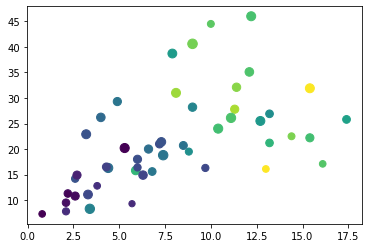

In [17]:
plt.scatter(arrests.iloc[:, 0], arrests.iloc[:, 3], arrests.iloc[:, 2], arrests.iloc[:, 1]);

# Apply clustering - scale the data first

In [18]:
scaler = StandardScaler()

In [19]:
scaler.fit(arrests)

StandardScaler()

- Very important to fit the scaler before transforming, because we'll apply the same scaler to new data we want to categorise.

In [20]:
scaler.mean_

array([  7.788, 170.76 ,  65.54 ,  21.232])

In [22]:
arrests_scaled = scaler.transform(arrests)

In [25]:
arrests_scaled_df = pd.DataFrame(arrests_scaled, columns=['murder', 'assault', 'urbanpop', 'rape'])

In [26]:
arrests_scaled_df.head()

,murder,assault,urbanpop,rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


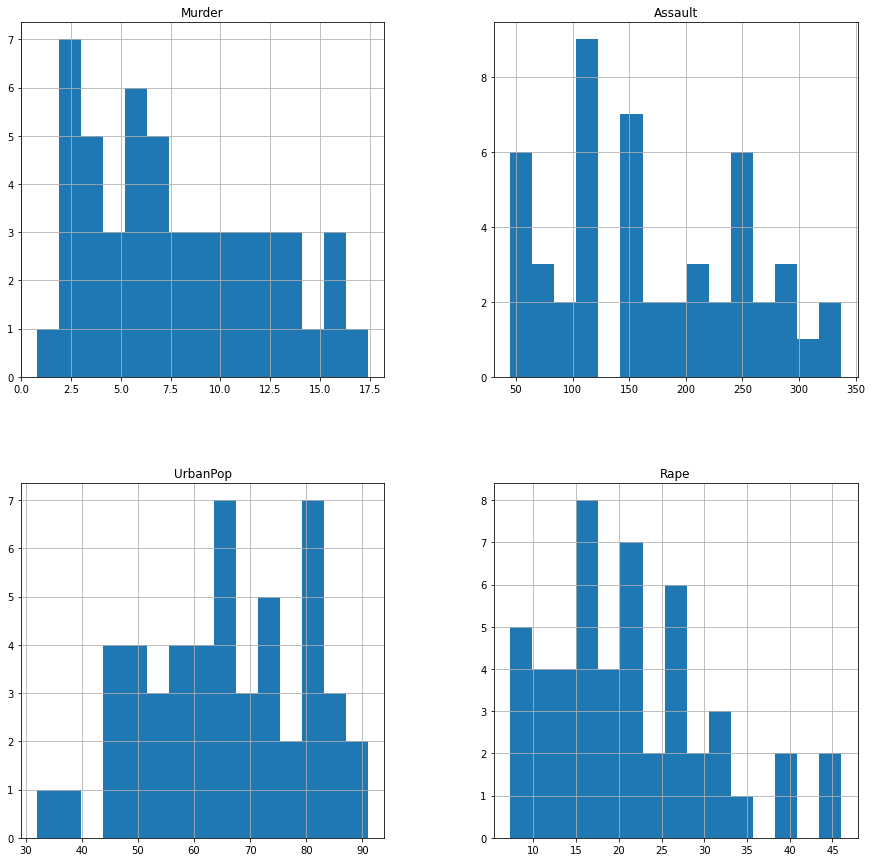

In [29]:
arrests.hist(bins=15, figsize=(15, 15));

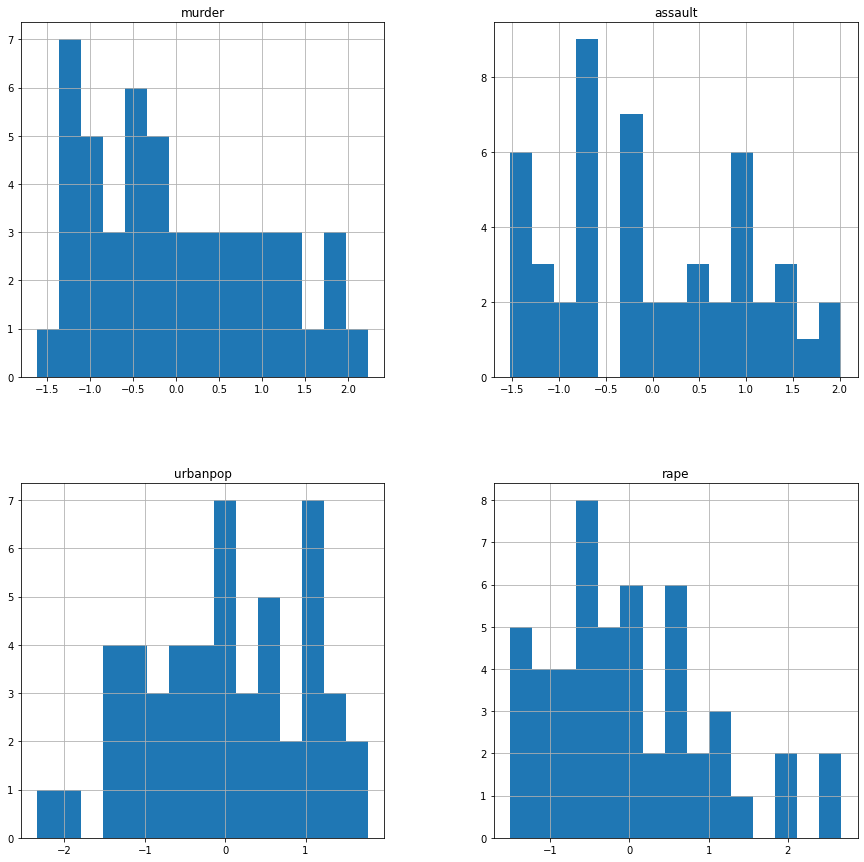

In [28]:
arrests_scaled_df.hist(bins=15, figsize=(15, 15));
# checking the shape. no change because of scaling

# Clustering

In [31]:
K_Means = KMeans(n_clusters=5, random_state=42)

In [32]:
cluster_arrests_sc = K_Means.fit(arrests_scaled_df)

In [33]:
cluster_arrests_sc.cluster_centers_

array([[-0.63817386, -0.38827513,  0.88223651, -0.27797516],
       [ 0.70212683,  1.04999438,  0.72997363,  1.28990383],
       [-0.15956455, -0.44557535, -0.39437496, -0.32460067],
       [ 1.59644066,  0.97606837, -0.78540457,  0.0489325 ],
       [-1.18467401, -1.2201201 , -1.01470522, -1.11321445]])

In [39]:
# counting uniques in array
unique, counts = np.unique(cluster_arrests_sc.labels_, return_counts=True)
print(dict(zip(unique, counts)))

{0: 11, 1: 13, 2: 9, 3: 7, 4: 10}


In [45]:
# adding the labels to the cluster
arrests_scaled_df['cluster_no'] = cluster_arrests_sc.labels_

In [47]:
# counting labels as df
arrests_scaled_df['cluster_no'].value_counts()

1    13
0    11
4    10
2     9
3     7
Name: cluster_no, dtype: int64

## Comparing the cluster assignment before and after scaling

In [51]:
cluster_nonscaled = K_Means.fit(arrests)

In [49]:
arrests_copy = arrests

In [52]:
arrests_copy['cluster'] = cluster_nonscaled.labels_

In [53]:
arrests_copy['cluster'].value_counts()

3    14
0    12
1    10
2    10
4     4
Name: cluster, dtype: int64

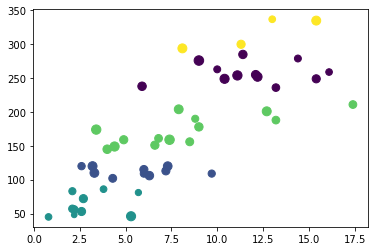

In [54]:
plt.scatter(arrests.iloc[:, 0], arrests.iloc[:, 1], arrests.iloc[:, 2], arrests.iloc[:, 4]);

In [60]:
arrests_copy.head()

,Murder,Assault,UrbanPop,Rape,cluster
Alabama,13.2,236,58,21.2,0
Alaska,10.0,263,48,44.5,0
Arizona,8.1,294,80,31.0,4
Arkansas,8.8,190,50,19.5,3
California,9.0,276,91,40.6,0


# 3D plotting

In [66]:
# Plotly: 
# size
markersize = arrests_copy['UrbanPop']
# colour = cluster
markercolour = arrests_copy['cluster']
# fig
fig1 = go.Scatter3d(x=arrests_copy['Murder'], 
                    y=arrests_copy['Rape'], 
                    z=arrests_copy['Assault'], 
                    marker=dict(size=markersize, 
                                color=markercolour, 
                                opacity=0.9, 
                                colorscale='Blues'), 
                    line=dict(width=0.2), 
                    mode='markers')
# layout
mylayout = go.Layout(scene=dict(xaxis=dict(title='Murder'),
                               yaxis=dict(title='Rape'),
                               zaxis=dict(title='Assault')))
# html offline plot
plotly.offline.plot({
    'data': [fig1],
    'layout': mylayout,
}, auto_open=True, filename=('5dplot.html'))

'5dplot.html'

# Picking the optimum K
3 metrics:
- inertia
- distortion
- silhouette score

In [70]:
cluster_arrests_sc.inertia_

24417.023523809523

In [78]:
test = arrests_scaled_df.drop(['cluster_no'], axis=1)

In [83]:
K = range(5, 18)
inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(test)
    inertia.append(kmeans.inertia_)

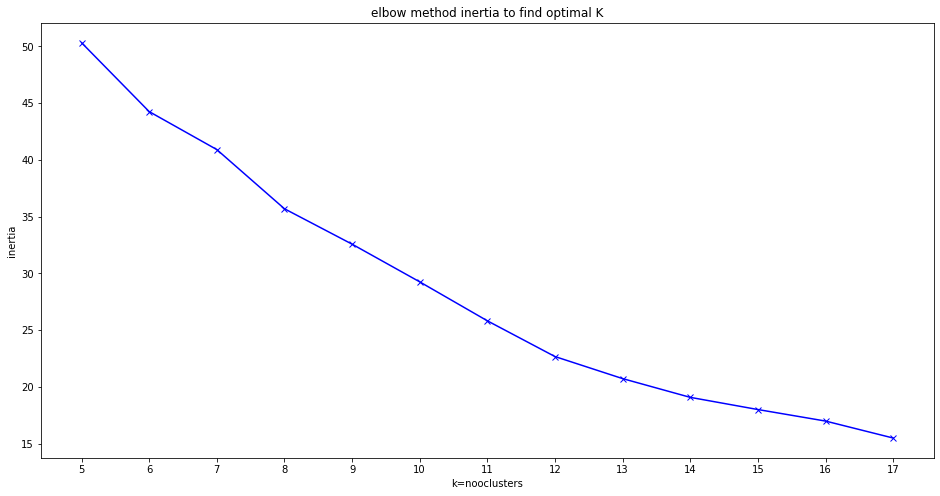

In [88]:
# plotting the inertia elbow
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k=nooclusters')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1,1.0))
plt.title('elbow method inertia to find optimal K');

In [85]:
K = range(5, 18)
sil = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(test)
    sil.append(silhouette_score(test, kmeans.predict(test)))

Silhouette score goes from -1 (incorrectly assigned) to 1 (perfectly assigned). We're looking for values from 0 to 1, and the closer to 1 the better.

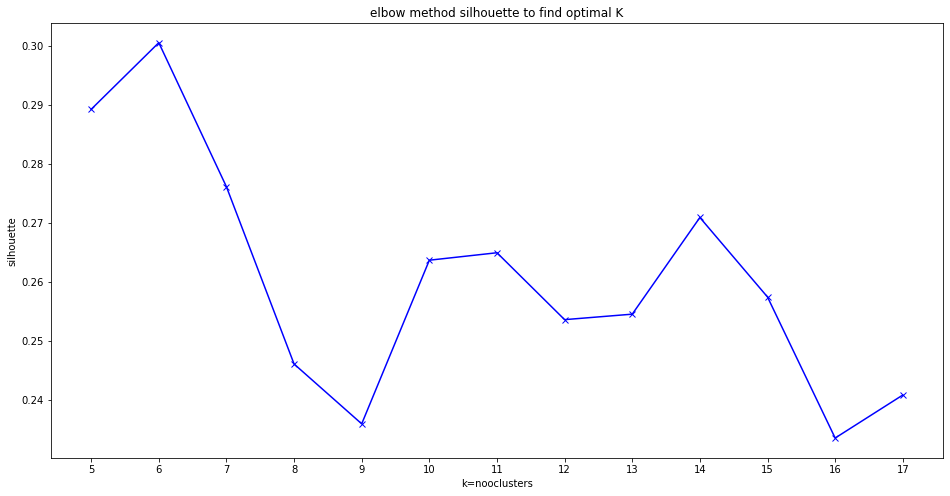

In [90]:
# plotting the solhouette elbow
plt.figure(figsize=(16,8))
plt.plot(K, sil, 'bx-')
plt.xlabel('k=nooclusters')
plt.ylabel('silhouette')
plt.xticks(np.arange(min(K), max(K)+1,1.0))
plt.title('elbow method silhouette to find optimal K');

# We go with k=8. Redo the cluster!

In [91]:
kmeans = KMeans(n_clusters=8, random_state=42)

In [92]:
CM = kmeans.fit(test)

In [93]:
test['cluster_final'] = CM.labels_

In [94]:
test['cluster_final'].value_counts()

7    8
2    8
3    8
5    8
1    7
0    7
4    3
6    1
Name: cluster_final, dtype: int64

# Introducing new data

In [105]:
new_d = {'Murder': [18], 'Assault': [320], 'UrbanPop': [60], 'Rape': [29]}

In [106]:
new_row = pd.DataFrame(data=new_d)
new_row

,Murder,Assault,UrbanPop,Rape
0,18,320,60,29


In [107]:
new_row_scaled = pd.DataFrame(scaler.transform(new_row), columns=['murder', 'assault', 'urbanpop', 'rape'])

In [129]:
kmeans.predict(new_row_scaled)[0]

1

In [114]:
new_row_cluster = 1

In [144]:
test[test.cluster_final == new_row_cluster].sample().index.values[0]

39

In [120]:
arrests.iloc[[17, 41]]

,Murder,Assault,UrbanPop,Rape,cluster
Louisiana,15.4,249,66,22.2,0
Tennessee,13.2,188,59,26.9,3
